In [1]:
# a small tutorial on how to use the main class of the repo "PathShadowing"
# this is done on very bad generated data ("gaussian") so don't trust the results
# use this code with your own data (both generated and observed)
import os 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
    
CACHE_PATH = Path(os.getcwd()) / '_cache'  # replace with your own cache path

# 1. Generated Dataset

The data generated data to look for close time-series ("shadowing" paths).

You should come up with your own generated market data (log-returns). 

here we choose white noise for simplicity (Black-Scholes model).

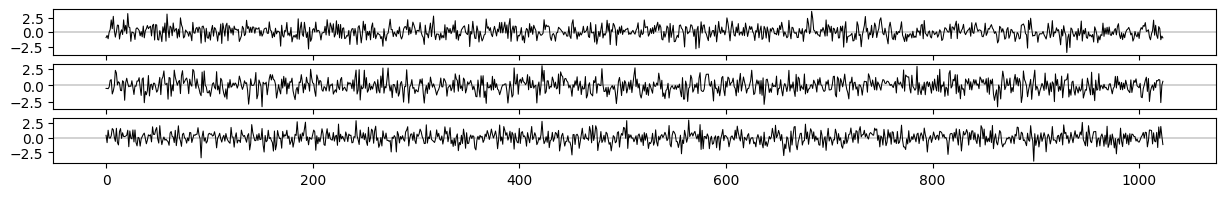

In [2]:
# manually create a gaussian dataset
from scatspectra import TimeSeriesDataset

R = 8192

dataset_path = CACHE_PATH / 'gaussian'
dataset_path.mkdir(parents=True, exist_ok=True)

for i_batch in range(R // 64):
    dlnx = np.random.randn(64, 1, 1024)
    np.save(dataset_path / f'{i_batch:04}.npy', dlnx)

dataset = TimeSeriesDataset(dpath=CACHE_PATH/'gaussian', R=R)  # replace woth your own log-return dataset

fig, axes = plt.subplots(3, 1, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.plot(dlnx[i,0,:], color='black', linewidth=0.75)
    ax.axhline(0.0, color='black', linewidth=0.25)

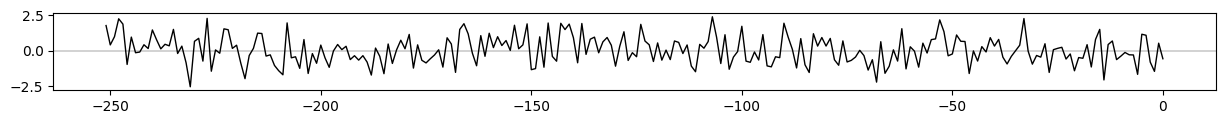

In [4]:
# observed data e.g. past time-series at different dates
np.random.seed(0)
x_past = np.random.randn(1,252)  # replace with your own data

plt.figure(figsize=(15,1))
plt.plot(np.arange(-252+1,1), x_past[0,:], color='black', linewidth=1.0)
plt.axhline(0.0, color='black', linewidth=0.25);

# 2. Path Shadowing

Given observed log-returns gather the closest paths from the generated dataset.

In [5]:
from shadowing import PathShadowing, FovealFixed, RelativeMSE

S = 4096  # number of paths in the dataset that will be used for path shadowing

# object for path shadowing
shadower = PathShadowing(x_past=x_past, 
                         dataset=dataset, 
                         S=S,
                         cache_path=CACHE_PATH,
                         dirname="shadowing_test",
                         n_splits=4,
                         verbose=True)

# embedding to reducing dimensionality
embedding = FovealFixed(alpha=1.15,  # cover the past at exponential speed 
                        beta=0.9,  # look with a weight power-law decay of 0.9
                        cut=126  # look at half-year in the observed past
                        )

# distance between reduced paths
distance = RelativeMSE()

# PERFORM PATH SHADOWING
distances, close_paths = shadower.shadow(embedding, distance, 
                                         n_paths=500,  # the number of closest paths (from generated dataset) to retain 
                                         horizon=252,  # the size of such paths in the future
                                         num_workers=6)

Global cache path. /mnt/home/rmorel/ceph/_cache/path_shadowing/shadowing_test_
Creating cache ...
Nb batches: 4, Avg batch size: 1024 (syntheses), Avg per batch 790,528 (paths of size 252)


Synthesis batch: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]

Loading cache ...
DONE.


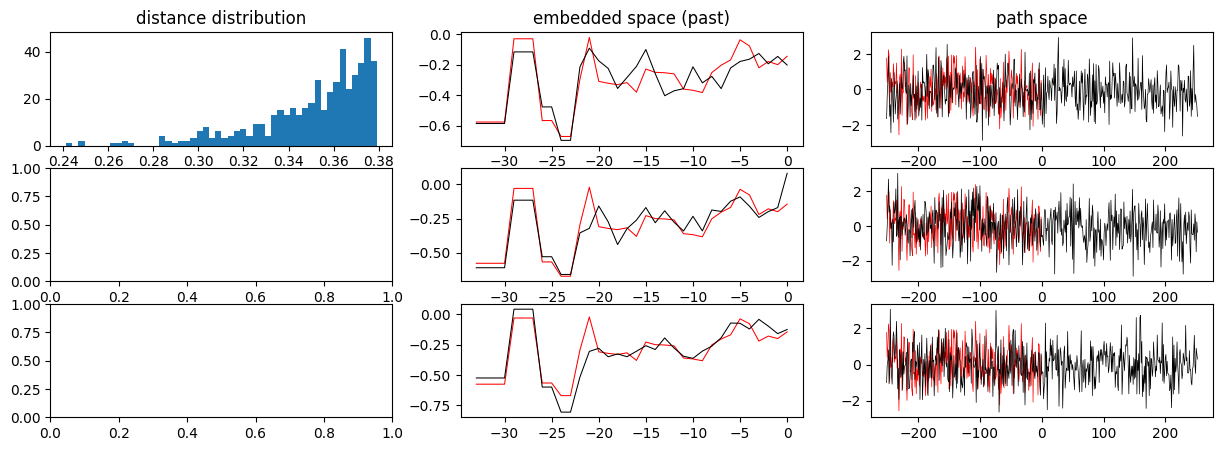

In [6]:
# some vizualization
from shadowing.utils import get_smallest

i_date = 0

w_past = x_past.shape[-1]
w_embed_past = embedding.dim
horizon = 252

# get 3 closest paths at this date
idces, ds = get_smallest(distances[i_date], 3)
x_closest = np.stack([close_paths[i_date][i_path] for i_path in idces])

# get their embedding
x_past_emb = embedding(x_past[:,:w_past])
x_closest_emb = embedding(x_closest[:,:w_past])

fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes[0,0].set_title('distance distribution')
axes[0,0].hist(distances, bins=50)
axes[0,1].set_title('embedded space (past)')
for i, ax in enumerate(axes[:,1]):
    ts_past = np.arange(-w_embed_past+1, 1)
    ax.plot(ts_past, x_past_emb[i_date,:w_embed_past], color='red', linewidth=0.75)
    ax.plot(ts_past, x_closest_emb[i,:w_embed_past], color='black', linewidth=0.75)
axes[0,2].set_title('path space')
for i, ax in enumerate(axes[:,2]):
    ts_past = np.arange(-w_past+1,1)
    ts = np.arange(-w_past+1,horizon+1)
    ax.plot(ts_past, x_past[i_date,:], color='red', linewidth=0.5)
    ax.plot(ts, x_closest[i,:], color='black', linewidth=0.5)
